In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import joblib
import notebook_helper
import sys
sys.path.append('../experiments/')
results_dir = '../results/'

Load the results into a pandas dataframe

In [2]:
dir_names = sorted([fname
                    for fname in os.listdir(results_dir)
                    if os.path.isdir(join(results_dir, fname))
                    and os.path.exists(join(results_dir, fname, 'results.pkl'))
                    ])
results_list = []
for dir_name in tqdm(dir_names):
    ser = pd.Series(
        joblib.load(join(results_dir, dir_name, 'results.pkl'))
    results_list.append(ser)

r = pd.concat(results_list, axis=1).T.infer_objects()
r.to_pickle(join(results_dir, 'results_aggregated.pkl'))

100%|██████████| 9/9 [00:00<00:00, 3711.04it/s]


In [ ]:
r

In [8]:
# fill missing args with default values from argparse
r = notebook_helper.fill_missing_args_with_default(r, fname='01_train_model.py')

# group using these experiment hyperparams when averaging over random seeds
group_keys = [k for k in notebook_helper.get_main_args_list(fname='01_train_model.py') if not k == 'seed']
ravg = (
    r
    .groupby(by=group_keys)
    .mean()
    .reset_index()
)

# apply cross validation
ravg_cv = (
    ravg
    .sort_values(by='accuracy_cv', ascending=False)
    .groupby(by=['model_name', 'dataset_name'])
    .first()
    .reset_index()
)
ravg_cv

/tmp/ipykernel_3250460/3844074043.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r


,model_name,dataset_name,subsample_frac,save_dir,alpha,max_depth,seed,use_cache,accuracy_train,accuracy_cv,accuracy_test
0,decision_tree,rotten_tomatoes,1.0,/home/chansingh/cookiecutter-ml-research/results,1.0,3,1.5,0.0,0.573403,0.566963,0.557223
1,ridge,rotten_tomatoes,1.0,/home/chansingh/cookiecutter-ml-research/results,1.0,2,1.5,0.0,0.998250,0.726110,0.719043


/home/chansingh/.embgam/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


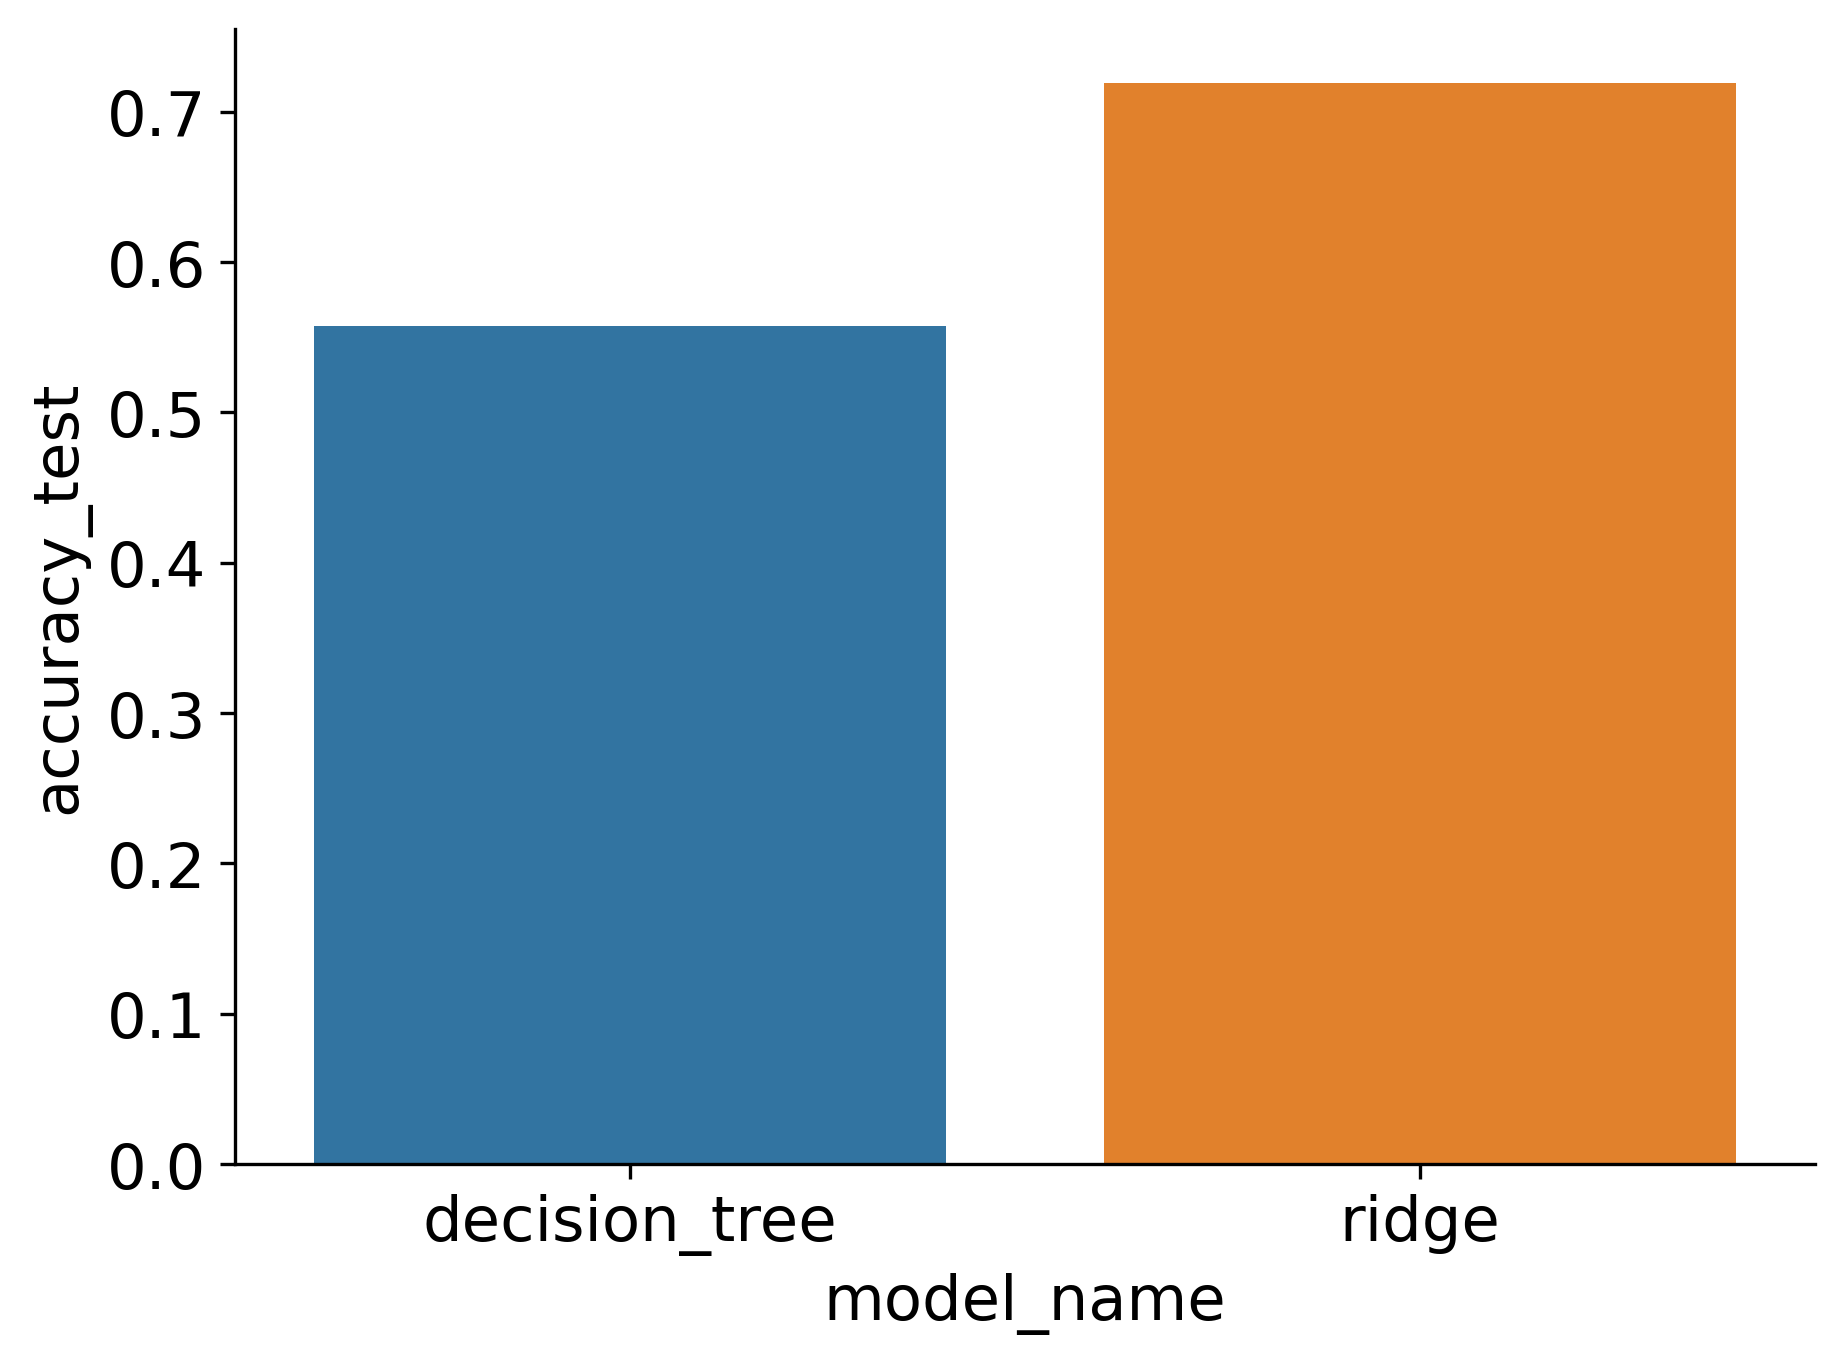

In [9]:
sns.barplot(data=ravg_cv, x='model_name', y='accuracy_test') #, hue='dataset_name')
plt.show()

Load an individual model

In [28]:
run_args = r.iloc[0]
model = joblib.load(join(run_args.save_dir_unique, 'model.pkl'))
model

DecisionTreeClassifier(max_depth=2)